In [1]:
#| default_exp tbats

# TBATS 

In [2]:
#| export
import os 
import numpy as np 
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from numba import njit 
from numpy import linalg as LA 
from scipy.optimize import minimize_scalar, fmin, minimize
from scipy.stats import f
from time import time 
from statsforecast.arima import auto_arima_f, arima_string

/Users/marianamenchero/Documents/statsforecast/statsforecast/core.py:24: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
#| export 
# Global variables 
NOGIL = os.environ.get('NUMBA_RELEASE_GIL', 'False').lower() in ['true']
CACHE = os.environ.get('NUMBA_CACHE', 'False').lower() in ['true']

## Load data 

In [4]:
#| hide 
# AirPassengers 
from statsforecast.utils import AirPassengers as ap 

# Electricity consumption 
import pandas as pd 
elec_df = pd.read_csv('tbats.files/PJMW_hourly.csv')
elec = elec_df['PJMW_MW']
elec = elec[0:(24*7*2+1)]
elec = np.array(elec)

# Calls 
calls_df = pd.read_csv('tbats.files/calls_data.csv')
calls = calls_df['calls']
calls = calls[-2001:]
calls = np.array(calls) 

## Box-Cox transformation

In [5]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def guer_cv(lam, x, season_length): 
    
    """
    Minimize this funtion to find the optimal parameter for the Box-Cox transformation.     
    """
    period = np.append(season_length, 2)
    period = np.round(np.max(period)) 
    n = len(x) 
    nyears = int(np.floor(n/period))
    nobs = np.floor(nyears*period)
    m = int(n-nobs)
    xmat = x[m:n].reshape((nyears, period))

    xmean = np.full(xmat.shape[0], fill_value = np.nan)
    for k in range(xmat.shape[0]): 
        xmean[k] = np.nanmean(xmat[k])

    xsd = np.full(xmat.shape[0], fill_value = np.nan)
    for k in range(xmat.shape[0]): 
        vals = xmat[k]
        svar = (vals-np.nanmean(vals))**2 
        svar = np.sum(svar)/(len(svar)-1) # sample variance 
        xsd[k] = np.sqrt(svar) # sample standard deviation 

    xrat = xsd/(xmean**(1-lam))

    sd = (xrat-np.nanmean(xrat))**2 # standard deviation 
    sd = np.nansum(sd)/(len(sd)-1)
    sd = np.sqrt(sd)
    
    return sd/np.nanmean(xrat)

In [6]:
#| exporti
def guerrero(x, season_length, lower=-1, upper=2): 
    
    """Finds optimal paramater for Box-Cox transformation using Guerrero's method"""
    
    if np.any(x < 0): 
        raise ValueError("Guerrero's method for selecting a Box-Cox parameter (lambda) is for strictly positive data")
    
    max_freq = np.max(season_length)
    if len(x) <= 2*max_freq: 
        res = np.array([1]) 
    else: 
        lam = 0 # initial guess 
        opt = minimize_scalar(guer_cv, lam, args = (x, season_length), method = 'bounded', bounds = (lower, upper))
        res = np.array([opt.x])
    
    return res

In [7]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def BoxCox(y, season_length, BoxCox_lambda): 
    
    """Applies Box-Cox transformation with parameter BoxCox_lambda"""
    
    if BoxCox_lambda == 0: 
        w = np.log(y)
    else: 
        w = np.sign(y)*((np.abs(y)**BoxCox_lambda)-1)
        w = w/BoxCox_lambda
        
    return w

In [8]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def InverseBoxCox(w, season_length, BoxCox_lambda): 
    
    """Inverts Box-Cox transformation with parameter BoxCox_lambda"""
    
    if BoxCox_lambda == 0: 
        y = np.exp(w) 
    else: 
        sign = np.sign(BoxCox_lambda*w+1)
        y = np.abs(BoxCox_lambda*w+1)**(1/BoxCox_lambda)
        y = sign*y 
        
    return y 

In [9]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def findPQ(ar_coeffs, ma_coeffs): 
    """
    Find the length of the AR coefficients (p) 
    and the length of the MA coefficients (q) 
    """
    if ar_coeffs is not None: 
        p = len(ar_coeffs) 
    else: 
        p = 0 
    if ma_coeffs is not None: 
        q = len(ma_coeffs) 
    else: 
        q = 0 
    return p, q

## TBATS functions 

### createXVector

In [10]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def createXVector(b, s_vector, d_vector, epsilon_vector): 
    l = 0.0
    x = np.array([l])
    if b is not None: 
        x = np.append(x, b)
    if s_vector is not None: 
        x = np.concatenate((x, s_vector))
    if d_vector is not None: 
        x = np.concatenate((x, d_vector)) 
    if epsilon_vector is not None: 
        x = np.concatenate((x, epsilon_vector))
    
    return x 

### createWMatrixTBATS

In [11]:
#| exporti
#@njit(nogil=NOGIL, cache=CACHE)
def createWMatrixTBATS(phi, k_vector, ar_coeffs, ma_coeffs, tau): 
    p, q = findPQ(ar_coeffs, ma_coeffs) 

    adjPhi = 0 
    numSeasonal = 0 
    numCols = 1

    if phi is not None: 
        adjPhi = 1 
        numCols = numCols+1
    if k_vector is not None: 
        numSeasonal = numSeasonal+len(k_vector) 
        numCols = numCols+tau 
    if ar_coeffs is not None: 
        numCols = numCols+p
    if ma_coeffs is not None: 
        numCols = numCols+q

    w_transpose = np.zeros((1, numCols))

    if k_vector is not None: 
        position = adjPhi 
        for s in range(0, numSeasonal):
            for j in range(position+1, position+k_vector[s]+1): 
                w_transpose[0,j] = 1 
            position = position+(2*k_vector[s])

    w_transpose[0,0] = 1

    if adjPhi == 1: 
        w_transpose[0,1] = phi

    if ar_coeffs is not None: 
        for i in range(1,p+1): 
            w_transpose[0,(adjPhi+tau+i)] = ar_coeffs[(i-1)]

    if ma_coeffs is not None: 
        for i in range(1,q+1): 
            w_transpose[0,(adjPhi+tau+p+i)] = ma_coeffs[(i-1)] 

    w = np.transpose(w_transpose) 

    return w_transpose, w 

### updateGammaBoldTBATS

In [12]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def updateGammaBoldTBATS(gamma_bold, k_vector, gamma_one_v, gamma_two_v): 
    endPos = 0 
    numK = len(k_vector) 

    for i in range(numK): 
        for j in range(endPos, (k_vector[i]+endPos)):
            gamma_bold[0,j] = gamma_one_v[i] 
        for k in range((k_vector[i]+endPos), (2*k_vector[i]+endPos)): 
            gamma_bold[0,k] = gamma_two_v[i]
        endPos = endPos + 2*k_vector[i] 

    return gamma_bold 

### updateGMatrixTBATS

In [13]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def updateGMatrixTBATS(g, gamma_bold, alpha, beta): 
    adjust_beta = 0 
    g[0,0] = alpha 
    if beta is not None: 
        g[1,0] = beta 
        adjust_beta = 1 
    if gamma_bold is not None:  
        g[(adjust_beta+1):(adjust_beta+gamma_bold.shape[1]+1), 0] = np.transpose(gamma_bold).reshape((gamma_bold.shape[1],))
    return g 

### createFMatrixTBATS

In [14]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def makeAIMatrix(C, S, ks): 
    Ai = np.zeros((ks*2,ks*2))
    Ai[0:ks, 0:ks] = C 
    Ai[0:ks, ks:(ks*2)] = S 
    Ai[ks:(ks*2), 0:ks] = -1*S
    Ai[ks:(ks*2), ks:(ks*2)] = C 
    return Ai

In [15]:
#| exporti
#@njit(nogil=NOGIL, cache=CACHE)
def createFMatrixTBATS(alpha, beta, phi, seasonal_periods, k_vector, gamma_bold, ar_coeffs, ma_coeffs): 
    p, q = findPQ(ar_coeffs, ma_coeffs) 

    # 1. Alpha row
    F = np.array([[1.0]])
    if beta is not None:
        F = np.concatenate((F, np.array([phi]).reshape(1,1)), axis = 1)
    if seasonal_periods is not None: 
        tau_v = 2*np.nansum(k_vector)
        zero_tau = np.zeros(tau_v).reshape(1, tau_v)
        F = np.concatenate((F, zero_tau), axis = 1) 
    if ar_coeffs is not None: 
        alpha_phi = alpha*ar_coeffs
        alpha_phi = alpha_phi.reshape(F.shape[0], alpha_phi.shape[0]) 
        F = np.concatenate((F, alpha_phi), axis = 1)
    if ma_coeffs is not None: 
        alpha_theta = alpha*ma_coeffs
        alpha_theta = alpha_theta.reshape(F.shape[0], alpha_theta.shape[0]) 
        F = np.concatenate((F, alpha_theta), axis = 1)

    # 2. Beta row 
    if beta is not None: 
        beta_row = np.array([[0, phi]]) 
        if seasonal_periods is not None: 
            beta_row = np.concatenate((beta_row, zero_tau), axis = 1)
        if ar_coeffs is not None: 
            beta_phi = beta*ar_coeffs 
            beta_phi = beta_phi.reshape(beta_row.shape[0], beta_phi.shape[0])
            beta_row = np.concatenate((beta_row, beta_phi), axis = 1) 
        if ma_coeffs is not None: 
            beta_theta = beta*ma_coeffs 
            beta_theta = beta_theta.reshape(beta_row.shape[0], beta_theta.shape[0]) 
            beta_row = np.concatenate((beta_row, beta_theta), axis = 1)
        F = np.concatenate((F, beta_row), axis = 0)
    
    # 3. Seasonal row 
    if seasonal_periods is not None: 
        seasonal_row = np.transpose(zero_tau)
        if beta is not None: 
            seasonal_row = np.concatenate((seasonal_row, seasonal_row), axis = 1)

        # Make A matrix 
        A = np.zeros((tau_v, tau_v))
        last_pos = 0 
        for i in range(len(k_vector)): 
            ks = k_vector[i] 
            ms = seasonal_periods[i]
            if seasonal_periods[i] != 2:
                C = np.zeros((ks,ks))
                for j in range(1,ks+1): 
                    l = (2*np.pi*j)/ms 
                    C[(j-1),(j-1)] = np.cos(l)
            else: 
                C = np.zeros((1,1))
            S = np.zeros((ks,ks))
            for j in range(1,ks+1): 
                l = (2*np.pi*j)/ms 
                S[(j-1),(j-1)] = np.sin(l)
            Ai = makeAIMatrix(C, S, ks)         
            A[last_pos:(last_pos+2*k_vector[i]), last_pos:(last_pos+2*k_vector[i])] = Ai 
            last_pos = last_pos+(2*k_vector[i])

        seasonal_row = np.concatenate((seasonal_row, A), axis = 1)
    
        if ar_coeffs is not None: 
            B = np.outer(gamma_bold, ar_coeffs)
            seasonal_row = np.concatenate((seasonal_row, B), axis = 1)
        if ma_coeffs is not None: 
            C = np.outer(gamma_bold, ma_coeffs) 
            seasonal_row = np.concatenate((seasonal_row, C), axis = 1) 

        F = np.concatenate((F, seasonal_row), axis = 0)

     # 4. AR rows 
    if ar_coeffs is not None: 
        p = len(ar_coeffs) 
        ar_rows = np.zeros((p, 1)) 
        if beta is not None: 
            ar_rows = np.concatenate((ar_rows, ar_rows), axis = 1) 
        if seasonal_periods is not None: 
            ar_seasonal_zeros = np.zeros((p, tau_v))
            ar_rows = np.concatenate((ar_rows, ar_seasonal_zeros), axis = 1) 
        ident = np.eye(p-1) 
        ident = np.concatenate((ident, np.zeros((p-1, 1))), axis = 1) 
        ar_part = np.concatenate((ar_coeffs.reshape(1, ar_coeffs.shape[0]), ident), axis = 0)
        ar_rows = np.concatenate((ar_rows, ar_part), axis = 1)
        if ma_coeffs is not None: 
            q = len(ma_coeffs)
            ma_in_ar = np.zeros((p, q)) 
            ma_in_ar[0,:] = ma_coeffs 
            ar_rows = np.concatenate((ar_rows, ma_in_ar), axis = 1)
        F = np.concatenate((F, ar_rows), axis = 0)

    # 5. MA rows 
    if ma_coeffs is not None: 
        q = len(ma_coeffs) 
        ma_rows = np.zeros((q, 1)) 
        if beta is not None: 
            ma_rows = np.concatenate((ma_rows, ma_rows), axis = 1)
        if seasonal_periods is not None: 
            ma_seasonal = np.zeros((q, tau_v))
            ma_rows = np.concatenate((ma_rows, ma_seasonal), axis = 1) 
        if ar_coeffs is not None: 
            ar_in_ma = np.zeros((q, p)) 
            ma_rows = np.concatenate((ma_rows, ar_in_ma), axis = 1) 
        ident = np.eye(q-1)
        ident = np.concatenate((ident, np.zeros((q-1, 1))), axis = 1) 
        ma_part = np.concatenate((np.zeros((1,q)), ident), axis = 0) 
        ma_rows = np.concatenate((ma_rows, ma_part), axis = 1) 
        F = np.concatenate((F, ma_rows), axis = 0)

    return F 

### calcTBATSFaster

In [16]:
#| exporti
# @njit(nogil=NOGIL, cache=CACHE)
def calcTBATSFaster(y_trans, w_transpose, g, F, x_nought): 

    n = y_trans.shape[0] 
    dimF = F.shape[0] 
    
    yhat = np.zeros((1,n))
    e = np.zeros((1,n))
    x = np.zeros((len(x_nought),n))

    yhat[0,0] = np.dot(w_transpose, x_nought).reshape(())
    e[0,0] = y_trans[0]-yhat[0,0] 
    x[:,0] = np.dot(F, x_nought)+(g*e[0,0]).reshape((dimF,))

    for j in range(1,y_trans.shape[0]): 
        yhat[:, j] = np.dot(w_transpose, np.ascontiguousarray(x[:, (j-1)]))
        e[0,j] = y_trans[j]-yhat[0,j]
        x[:,j] = (np.dot(F,x[:,(j-1)]).reshape((dimF,1))+g*e[0,j]).reshape((dimF,))
        
    return yhat, e, x

### updateWtransposeMatrix

In [17]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def updateWtransposeMatrix(w_transpose, phi, tau, ar_coeffs, ma_coeffs):
    p, q = findPQ(ar_coeffs, ma_coeffs) 
    adjBeta = 0 
    if phi is not None: 
        adjBeta = 1 
        w_transpose[0,1] = phi 
    if p > 0: 
        if ar_coeffs is not None:
            for i in range(1,p+1): 
                w_transpose[0, adjBeta+tau+i] = ar_coeffs[i-1]
        if q > 0: 
            if ma_coeffs is not None: 
                for i in range(1,q+1): 
                    w_transpose[0, adjBeta+tau+p+i] = ma_coeffs[i-1]
    elif q > 0: 
        if ma_coeffs is not None: 
            for i in range(1,q+1): 
                w_transpose[0, adjBeta+tau+i] = ma_coeffs[i-1]
    return w_transpose

### updateFMatrixTBATS

In [18]:
#| exporti
#@njit(nogil=NOGIL, cache=CACHE)
def updateFMatrixTBATS(F, phi, alpha, beta, gamma_bold, ar_coeffs, ma_coeffs, tau):
    if beta is not None: 
        F[0,1] = phi 
        F[1,1] = phi 
        betaAdjust = 1
    else: 
        betaAdjust = 0 
    p, q = findPQ(ar_coeffs, ma_coeffs)
    if ar_coeffs is not None:
        F[0, (betaAdjust+tau+1):(betaAdjust+tau+p+1)] = alpha*ar_coeffs
        if betaAdjust == 1:  
            F[1, (betaAdjust+tau+1):(betaAdjust+tau+p+1)] = beta*ar_coeffs 
        if tau > 0: 
            B = np.dot(gamma_bold.reshape((gamma_bold.shape[1],1)), ar_coeffs.reshape((1,ar_coeffs.shape[0])))
            F[(1+betaAdjust):(betaAdjust+tau+1), (betaAdjust+tau+1):(betaAdjust+tau+p+1)] = B 
        F[betaAdjust+tau+1,(betaAdjust+tau+1):(betaAdjust+tau+p+1)] = ar_coeffs 
    if ma_coeffs is not None: 
        F[0, (betaAdjust+tau+p+1):(betaAdjust+tau+p+q+1)] = alpha*ma_coeffs 
        if betaAdjust == 1:  
            F[1, (betaAdjust+tau+p+1):(betaAdjust+tau+p+q+1)] = beta*ma_coeffs
        if tau > 0: 
            C = np.dot(gamma_bold.reshape((gamma_bold.shape[1],1)),ma_coeffs.reshape((1,ma_coeffs.shape[0]))) 
            F[(1+betaAdjust):(betaAdjust+tau+1), (betaAdjust+tau+p+1):(betaAdjust+tau+p+q+1)] = C 
        F[betaAdjust+tau+1,(betaAdjust+tau+p+1):(betaAdjust+tau+p+q+1)] = ma_coeffs 

    return F 

### checkAdmissibility

In [19]:
#| exporti
def checkAdmissibility(BoxCox_lambda, bc_lower_bound, bc_upper_bound, phi, ar_coeffs, ma_coeffs, D): 
    if BoxCox_lambda is not None: 
        if (BoxCox_lambda < bc_lower_bound) or (BoxCox_lambda > bc_upper_bound): 
            return False 

    if phi is not None: 
        if (phi < 0.8) or (phi > 1): 
            return False 
        
    if ar_coeffs is not None:
        ar_lags = np.where(np.abs(ar_coeffs) > 1e-8) 
        ar_count = (np.abs(ar_coeffs) > 1e-8).sum()
        if  ar_count > 0: 
            pval = np.max(ar_lags) 
            poly = np.polynomial.Polynomial([1]+[-ar_coeffs[i] for i in range(pval+1)])
            roots = poly.roots()
            if min(np.abs(roots)) < 1+1e-2: 
                return False 
            
    if ma_coeffs is not None: 
        ma_lags = np.where(np.abs(ma_coeffs) > 1e-8) 
        ma_count = (np.abs(ma_coeffs) > 1e-8).sum()
        if len(ma_lags) > 0: 
            qval = np.max(ma_lags) 
            poly = np.polynomial.Polynomial([1]+[-ma_coeffs[i] for i in range(qval+1)])
            roots = poly.roots()
            if min(np.abs(roots)) < 1+1e-2: 
                return False 
  
    D_eigen_values = LA.eigvals(D)
    return np.all(abs(D_eigen_values) < 1+1e-2)

### extract_params 

In [20]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def set_arma_errors(ar_coeffs, ma_coeffs): 
    if len(ar_coeffs) == 0: 
        ar_coeffs = None 
    if len(ma_coeffs) == 0: 
        ma_coeffs = None
    return ar_coeffs, ma_coeffs

In [21]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def extract_params(params, seasonal_periods, use_boxcox, use_trend, use_damped_trend, use_arma_errors, p, q): 
    if use_boxcox: 
        BoxCox_lambda = params[0]
        alpha = params[1]
        index = 2
    else: 
        BoxCox_lambda = None
        alpha = params[0] 
        index = 1 
    if use_trend and use_damped_trend and use_arma_errors:         
        beta = params[index] 
        phi = params[index+1] 
        gamma_one_v = params[(index+2):(index+2+len(seasonal_periods))]
        gamma_two_v = params[(index+2+len(seasonal_periods)):(index+2+2*len(seasonal_periods))]
        ar_coeffs = params[(index+2+2*len(seasonal_periods)):(index+2+2*len(seasonal_periods)+p)]
        ma_coeffs = params[(index+2+2*len(seasonal_periods)+p):(index+2+2*len(seasonal_periods)+p+q)]
        ar_coeffs, ma_coeffs = set_arma_errors(ar_coeffs, ma_coeffs)
    elif use_trend and use_damped_trend and (not use_arma_errors): 
        beta = params[index] 
        phi = params[index+1] 
        gamma_one_v = params[(index+2):(index+2+len(seasonal_periods))]
        gamma_two_v = params[(index+2+len(seasonal_periods)):(index+2+2*len(seasonal_periods))]
        ar_coeffs = None 
        ma_coeffs = None
    elif use_trend and (not use_damped_trend) and use_arma_errors: 
        beta = params[index] 
        phi = 1
        gamma_one_v = params[(index+2):(index+2+len(seasonal_periods))] 
        gamma_two_v = params[(index+2+len(seasonal_periods)):(index+2+2*len(seasonal_periods))]
        ar_coeffs = params[(index+2+2*len(seasonal_periods)):(index+2+2*len(seasonal_periods)+p)]
        ma_coeffs = params[(index+2+2*len(seasonal_periods)+p):(index+2+2*len(seasonal_periods)+p+q)] 
        ar_coeffs, ma_coeffs = set_arma_errors(ar_coeffs, ma_coeffs)
    elif use_trend and (not use_damped_trend) and (not use_arma_errors): 
        beta = params[index] 
        phi = 1 
        gamma_one_v = params[(index+2):(index+2+len(seasonal_periods))] 
        gamma_two_v = params[(index+2+len(seasonal_periods)):(index+2+2*len(seasonal_periods))]
        ar_coeffs = None
        ma_coeffs = None 
    elif (not use_trend) and (not use_damped_trend) and use_arma_errors: 
        beta = None
        phi = None
        gamma_one_v = params[index:(index+len(seasonal_periods))] 
        gamma_two_v = params[(index+len(seasonal_periods)):(index+2*len(seasonal_periods))]
        ar_coeffs = params[(index+2*len(seasonal_periods)):(index+1+2*len(seasonal_periods)+p)]
        ma_coeffs = params[(index+2*len(seasonal_periods)+p):(index+1+2*len(seasonal_periods)+p+q)] 
        ar_coeffs, ma_coeffs = set_arma_errors(ar_coeffs, ma_coeffs)
    elif (not use_trend) and (not use_damped_trend) and (not use_arma_errors): 
        beta = None
        phi = None
        gamma_one_v = params[index:(index+len(seasonal_periods))]
        gamma_two_v = params[(index+len(seasonal_periods)):(index+2*len(seasonal_periods))]
        ar_coeffs = None
        ma_coeffs = None
    else: 
        raise ValueError("use_trend can't be set to False if use_damped_trend is set to True")
        
    return BoxCox_lambda, alpha, beta, phi, gamma_one_v, gamma_two_v, ar_coeffs, ma_coeffs 

### calcLikelihoodTBATS

In [22]:
#| exporti
def calcLikelihoodTBATS(params, use_boxcox, use_trend, use_damped_trend, use_arma_errors, y_trans, seasonal_periods, k_vector, tau, w_transpose, F, g, gamma_bold, x_nought, bc_lower_bound, bc_upper_bound, p, q): 
    n = len(y_trans)
    
    BoxCox_lambda, alpha, beta, phi, gamma_one_v, gamma_two_v, ar_coeffs, ma_coeffs = extract_params(params, seasonal_periods, use_boxcox, use_trend, use_damped_trend, use_arma_errors, p, q)
    
    w_transpose = updateWtransposeMatrix(w_transpose, phi, tau, ar_coeffs, ma_coeffs) 
    gamma_bold = updateGammaBoldTBATS(gamma_bold, k_vector, gamma_one_v, gamma_two_v)
    g = updateGMatrixTBATS(g, gamma_bold, alpha, beta)
    F = updateFMatrixTBATS(F, phi, alpha, beta, gamma_bold, ar_coeffs, ma_coeffs, tau)
    
    _, e, x = calcTBATSFaster(y_trans, w_transpose, g, F, x_nought)
    
    if use_boxcox: 
        log_likelihood = n*np.log(np.nansum(e**2))-2*(BoxCox_lambda-1)*np.nansum(np.log(y_trans)) 
    else: 
        log_likelihood = n*np.log(np.nansum(e**2))
    
    D = F-np.dot(g, w_transpose)
    
    if checkAdmissibility(BoxCox_lambda, bc_lower_bound, bc_upper_bound, phi, ar_coeffs, ma_coeffs, D): 
        return log_likelihood 
    else: 
        return 10**20

### compute_sigmah

In [23]:
#| exporti
def _compute_sigmah(obj, h): 
    """
    Computes the sigmah requiered for prediction intervals
    """
    var_mult = np.zeros((h,))
    var_mult[0] = 1
    if h > 1:
        for j in range(1,h):
            if j == 1:
                f_running = np.eye(obj['F'].shape[1])
            else:
                f_running = np.dot(f_running, obj['F'])
            cj = np.dot(np.dot(obj['w_transpose'], f_running), obj['g'])
            var_mult[j] = var_mult[j-1]+cj**2
    sigma2h = obj['sigma2']*var_mult    
    sigmah = np.sqrt(sigma2h)
    return sigmah 

## TBATS model 

### tbats_starting_params

In [24]:
#| exporti
def tbats_starting_params(seasonal_periods, k_vector, use_trend, use_damped_trend, ar_coeffs, ma_coeffs):
    alpha = 0.09

    if use_trend: 
        adjBeta = 1 
        beta = 0.05 
        b = 0.0
        if use_damped_trend: 
            phi = 0.999 
        else: 
            phi = 1 
    else: 
        adjBeta = 0 
        beta = None 
        b = None 
        phi = None 
        
    if seasonal_periods is not None: 
        gamma_one_v = np.zeros((len(seasonal_periods),))
        gamma_two_v = np.zeros((len(seasonal_periods),)) 
        s_vector = np.zeros((np.nansum(k_vector)*2,))
    else: 
        gamma_one_v = None 
        gamma_two_v = None 
        s_vector = None

    if ar_coeffs is not None: 
        d_vector = np.zeros((len(ar_coeffs),)) 
    else: 
        d_vector = None
        
    if ma_coeffs is not None: 
        epsilon_vector = np.zeros((len(ma_coeffs),)) 
    else: 
        epsilon_vector = None 

    return alpha, adjBeta, b, beta, phi, gamma_one_v, gamma_two_v, s_vector, d_vector, epsilon_vector

### tbats_model_generator

In [25]:
#| exporti
def tbats_model_generator(y, seasonal_periods, k_vector, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors, alpha, adjBeta, b, beta, phi, gamma_one_v, gamma_two_v, s_vector, d_vector, epsilon_vector, ar_coeffs, ma_coeffs): 

    n = len(y)
    p, q = findPQ(ar_coeffs, ma_coeffs) 

    # Box-Cox transformation
    if use_boxcox: 
        BoxCox_lambda = guerrero(y, seasonal_periods, lower = bc_lower_bound, upper = bc_upper_bound) 
        y_trans = BoxCox(y, seasonal_periods, BoxCox_lambda) 
    else: 
        BoxCox_lambda = None
        y_trans = y 

    if seasonal_periods is not None: 
        tau = 2*sum(k_vector) 
        tau = tau.astype('int')
    else: 
        tau = 0

    # Set up matrices 
    x_nought = createXVector(b, s_vector, d_vector, epsilon_vector) 

    w_transpose, _ = createWMatrixTBATS(phi, k_vector, ar_coeffs, ma_coeffs, tau)

    if seasonal_periods is not None: 
        gamma_bold = np.zeros((1, 2*np.nansum(k_vector)))
        gamma_bold = updateGammaBoldTBATS(gamma_bold, k_vector, gamma_one_v, gamma_two_v)
    else: 
        gamma_bold = None   
    g = np.zeros((2*np.nansum(k_vector)+1+adjBeta+p+q, 1)) 
    if p != 0: 
        g[(adjBeta+tau+1),0] = 1 
    if q != 0: 
        g[(adjBeta+tau+p+1),0] = 1
    g = updateGMatrixTBATS(g, gamma_bold, alpha, beta)

    F = createFMatrixTBATS(alpha, beta, phi, seasonal_periods, k_vector, gamma_bold, ar_coeffs, ma_coeffs) 

    D = F-np.dot(g, w_transpose) 

    # Find seed states 
    _, e, x = calcTBATSFaster(y_trans, w_transpose, g, F, x_nought) # R code assigns e to a variable called y.tilda. Here we'll use e directly 

    w_tilda_transpose = np.zeros((n, w_transpose.shape[1]))
    w_tilda_transpose[0,:] = w_transpose 

    for k in range(1, w_tilda_transpose.shape[0]): 
        w_tilda_transpose[k,:] = np.dot(w_tilda_transpose[k-1,:], D)

    if p != 0 or q!= 0: 
        end_cut = w_tilda_transpose.shape[1] 
        start_cut = end_cut-(p+q)
        cols = np.arange(0, w_tilda_transpose.shape[1], 1)
        new_cols = np.delete(cols, np.arange(start_cut, end_cut, 1))
        w_tilda_transpose = w_tilda_transpose[:, new_cols]

    model = sm.OLS(e.reshape((e.shape[1],1)), w_tilda_transpose).fit()
    x_nought = model.params

    if (p != 0 or q != 0):
        arma_seed_states = np.zeros((p+q,))
        x_nought = np.concatenate((x_nought, arma_seed_states))

    # Create vector with parameters 
    if use_boxcox: 
        params = np.concatenate([BoxCox_lambda, np.array([alpha])]) 
    else:  
        params = np.array([alpha])
    if beta is not None:  
        params = np.concatenate([params, np.array([beta])])
    if phi is not None: 
        params = np.concatenate([params, np.array([phi])]) 
    params = np.concatenate([params, gamma_one_v, gamma_two_v])
    if ar_coeffs is not None: 
        params = np.concatenate([params, ar_coeffs])
    if ma_coeffs is not None: 
        params = np.concatenate([params, ma_coeffs])

    # Solve optimization problem 
    # start = time()
    # optim_params = fmin(calcLikelihoodTBATS, 
    #                     params, 
    #                     args = (use_boxcox, use_trend, use_damped_trend, use_arma_errors, y_trans, seasonal_periods, k_vector, tau, w_transpose, F, g, gamma_bold, x_nought, bc_lower_bound, bc_upper_bound, p, q), 
    #                     maxiter = 2000,
    #                     disp = False
    #                     )

    optim_params = minimize(calcLikelihoodTBATS,
                            params,
                            args = (use_boxcox, use_trend, use_damped_trend, use_arma_errors, y_trans, seasonal_periods, k_vector, tau, w_transpose, F, g, gamma_bold, x_nought, bc_lower_bound, bc_upper_bound, p, q), 
                            method = 'Nelder-Mead',
                            options = {'maxiter': 2000, 'disp': False}
                            ).x
    # end = time() 
    #print('Optimization problem: '+str(end-start)) 
    
    _, optim_alpha, optim_beta, optim_phi, optim_gamma_one_v, optim_gamma_two_v, optim_ar_coeffs, optim_ma_coeffs = extract_params(optim_params, seasonal_periods, use_boxcox, use_trend, use_damped_trend, use_arma_errors, p, q)

    # In practice, it's better to use the original boxcox lambda instead of the optimized one

    w_transpose, _ = createWMatrixTBATS(optim_phi, k_vector, optim_ar_coeffs, optim_ma_coeffs, tau)
    gamma_bold = updateGammaBoldTBATS(gamma_bold, k_vector, optim_gamma_one_v, optim_gamma_two_v)
    g = updateGMatrixTBATS(g, gamma_bold, optim_alpha, optim_beta)
    F = updateFMatrixTBATS(F, optim_phi, optim_alpha, optim_beta, gamma_bold, optim_ar_coeffs, optim_ma_coeffs, tau)

    fitted, errors, x = calcTBATSFaster(y_trans, w_transpose, g, F, x_nought)

    sigma2 = np.sum(errors*errors)/n

    # Calculate likelihood 
    if use_boxcox: 
        likelihood = n*np.log(np.nansum(e**2))-2*(BoxCox_lambda-1)*np.nansum(np.log(y)) 
    else: 
        likelihood = n*np.log(np.nansum(e**2))

    # Calculate AIC
    aic = likelihood+2*(len(optim_params)+x_nought.shape[0])
    
    # Average errors 
    avg_e = np.nanmean(abs(errors))

    res = {
        'fitted': fitted, 
        'errors': errors, 
        'avg_e': avg_e,
        'sigma2': sigma2, 
        'aic': aic,
        'optim_params': optim_params,
        'BoxCox_lambda': BoxCox_lambda,
        'F': F, 
        'w_transpose': w_transpose,
        'g': g,
        'x': x, 
        'k_vector': k_vector,
        'p': p, 
        'q': q
    }

    return res

### tbats_model 

In [26]:
#| exporti
def tbats_model(y, 
                seasonal_periods, 
                use_boxcox,
                bc_lower_bound,
                bc_upper_bound, 
                use_trend, 
                use_damped_trend, 
                use_arma_errors,
               ): 

    seasonal_periods = np.sort(seasonal_periods)
    k_vector = np.full((len(seasonal_periods),), fill_value = 1) # initial k_vector 

    # Check if there are missing values 
    indices = np.where(np.isnan(y))[0]
    if len(indices) > 0: 
        max_index = indices[-1]
        y = y[max_index+1:len(y)]

    # Check if there are negative values 
    if np.any(y < 0): 
        use_boxcox = False 

    # Create first model 
    ar_coeffs = None
    ma_coeffs = None
    p, q = findPQ(ar_coeffs, ma_coeffs)

    # Starting parameters 
    alpha, adjBeta, b, beta, phi, gamma_one_v, gamma_two_v, s_vector, d_vector, epsilon_vector = tbats_starting_params(seasonal_periods, k_vector, use_trend, use_damped_trend, ar_coeffs, ma_coeffs)

    # First model 
    # No ARMA errors. This model is used to select the order of Fourier terms (k_vector)
    # ------------------------------------------------------------------------------------------
    ## Fit a TBATS model with the initial k_vector
    best_model = tbats_model_generator(y, seasonal_periods, k_vector, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors, alpha, adjBeta, b, beta, phi, gamma_one_v, gamma_two_v, s_vector, d_vector, epsilon_vector, ar_coeffs, ma_coeffs)
    best_model_aic = best_model['aic']

    for i in range(len(seasonal_periods)): 
        if seasonal_periods[i] == 2: 
            continue
        max_k = np.floor((seasonal_periods[i]-1)/2)
        if i != 1: 
            current_k = 2 
            while current_k <= max_k:
                if seasonal_periods[i] % current_k != 0: 
                    current_k = current_k+1
                    continue
                latter = seasonal_periods[i]/current_k

                if any([x % latter == 0 for x in seasonal_periods[:i]]): 
                    max_k = current_k-1
                    break
                else:
                    current_k = current_k+1
        if max_k == 1: 
            continue 
        if max_k <= 6:
            k_vector[i] = max_k
            _, _, _, _, _, _, _, s_vector, d_vector, epsilon_vector = tbats_starting_params(seasonal_periods, k_vector, use_trend, use_damped_trend, ar_coeffs, ma_coeffs)
            new_model = tbats_model_generator(y, seasonal_periods, k_vector, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors, alpha, adjBeta, b, beta, phi, gamma_one_v, gamma_two_v, s_vector, d_vector, epsilon_vector, ar_coeffs, ma_coeffs)
            new_model_aic = new_model['aic']
            if new_model_aic > best_model_aic: 
                k_vector[i] = k_vector[i]+1
                break
            else: 
                if k_vector[i] == 1: 
                    break
                k_vector[i] = k_vector[i]-1
                best_model = new_model 
        else: 
            # Three different k vectors 
            step_up_k = k_vector 
            step_down_k = k_vector 
            step_up_k[i] = 7 
            step_down_k[i] = 5 
            k_vector[i] = 6 

            # Fit three different models 
            _, _, _, _, _, _, _, s_vector, d_vector, epsilon_vector = tbats_starting_params(seasonal_periods, step_up_k, use_trend, use_damped_trend, ar_coeffs, ma_coeffs)
            up_model = tbats_model_generator(y, seasonal_periods, step_up_k, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors, alpha, adjBeta, b, beta, phi, gamma_one_v, gamma_two_v, s_vector, d_vector, epsilon_vector, ar_coeffs, ma_coeffs)

            _, _, _, _, _, _, _, s_vector, d_vector, epsilon_vector = tbats_starting_params(seasonal_periods, step_down_k, use_trend, use_damped_trend, ar_coeffs, ma_coeffs) 
            down_model = tbats_model_generator(y, seasonal_periods, step_down_k, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors, alpha, adjBeta, b, beta, phi, gamma_one_v, gamma_two_v, s_vector, d_vector, epsilon_vector, ar_coeffs, ma_coeffs)
            
            _, _, _, _, _, _, _, s_vector, d_vector, epsilon_vector = tbats_starting_params(seasonal_periods, k_vector, use_trend, use_damped_trend, ar_coeffs, ma_coeffs)
            level_model = tbats_model_generator(y, seasonal_periods, k_vector, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors, alpha, adjBeta, b, beta, phi, gamma_one_v, gamma_two_v, s_vector, d_vector, epsilon_vector, ar_coeffs, ma_coeffs)

            # Select the best model and follow that direction to find the optimal k 
            up_model_aic = up_model['aic']
            down_model_aic = down_model['aic']
            level_model_aic = level_model['aic']

            aic_vector = np.array([up_model_aic, level_model_aic, down_model_aic])
            min_aic = np.min(aic_vector)

            # If shifting down 
            if min_aic == down_model_aic: 
                best_model = down_model 
                k_vector[i] = 5 
                while True: 
                    k_vector[i] = k_vector[i]-1
                    _, _, _, _, _, _, _, s_vector, d_vector, epsilon_vector = tbats_starting_params(seasonal_periods, k_vector, use_trend, use_damped_trend, ar_coeffs, ma_coeffs)
                    down_model = tbats_model_generator(y, seasonal_periods, k_vector, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors, alpha, adjBeta, b, beta, phi, gamma_one_v, gamma_two_v, s_vector, d_vector, epsilon_vector, ar_coeffs, ma_coeffs)
                    down_model_aic = down_model['aic']
                    if down_model_aic > best_model_aic: 
                        k_vector[i] = k_vector[i]+1
                        break
                    else:
                        best_model = down_model
                    if k_vector[i] == 1: 
                        break  

            elif min_aic == level_model_aic: # if staying level
                best_model = level_model 
                continue 

            else: # if shifting up 
                best_model = up_model 
                k_vector[i] = 7

                while True: 
                    k_vector[i] = k_vector[i]+1
                    _, _, _, _, _, _, _, s_vector, d_vector, epsilon_vector = tbats_starting_params(seasonal_periods, k_vector, use_trend, use_damped_trend, ar_coeffs, ma_coeffs)
                    up_model = tbats_model_generator(y, seasonal_periods, k_vector, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors, alpha, adjBeta, b, beta, phi, gamma_one_v, gamma_two_v, s_vector, d_vector, epsilon_vector, ar_coeffs, ma_coeffs)
                    up_model_aic = up_model['aic']
                    if up_model_aic > best_model_aic: 
                        k_vector[i] = k_vector[i]-1
                        break 
                    else: 
                        best_model = up_model 
                    if k_vector[i] == max_k: 
                        break
    # ------------------------------------------------------------------------------------------
    optim_k_vector = k_vector 

    best_model['description'] = 'Model without ARMA errors'
    best_model['k_vector'] = optim_k_vector

    # Second model 
    # Uses ARMA errors and the k_vector from the first model
    if use_arma_errors: 
        try: 
            errors = best_model['errors'][0] # ARMA errors from first model 
            with np.errstate(invalid="ignore"):
                fit = auto_arima_f(errors, d = 0)
            p = int(arima_string(fit)[6])
            q = int(arima_string(fit)[10])
            if p != 0: 
                ar_coeffs = np.zeros((p,)) 
            else: 
                ar_coeffs = None 
            if q != 0: 
                ma_coeffs = np.zeros((q,))
            else: 
                ma_coeffs = None
            _, _, _, _, _, _, _, s_vector, d_vector, epsilon_vector = tbats_starting_params(seasonal_periods, optim_k_vector, use_trend, use_damped_trend, ar_coeffs, ma_coeffs)                    
            _, optim_alpha, optim_beta, optim_phi, optim_gamma_one_v, optim_gamma_two_v, _, _ = extract_params(best_model['optim_params'], seasonal_periods, use_boxcox, use_trend, use_damped_trend, use_arma_errors, p, q)
            model_arma_errors = tbats_model_generator(y, seasonal_periods, optim_k_vector, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors, optim_alpha, adjBeta, b, optim_beta, optim_phi, optim_gamma_one_v, optim_gamma_two_v, s_vector, d_vector, epsilon_vector, ar_coeffs, ma_coeffs)
            if model_arma_errors['aic'] < best_model['aic']: 
                best_model = model_arma_errors
                best_model['description'] = 'Model with ARMA errors'

        except:
            return best_model
    
    return best_model 

### tbats_selection

In [27]:
#| exporti
def tbats_selection(y, 
                    seasonal_periods,
                    bc_lower_bound, 
                    bc_upper_bound
                    ): 
        
    combinations = []

    for BC in [True, False]: # Possible values for use_boxcox
        for T in [[True, True],[True, False],[False, False]]: # Possible values for use_trend and use_damped_trend  
            for A in [True]: # Possible values for use_arma_errors [True, False]
                combinations.append((BC, T, A))

    for k in range(len(combinations)): 
        use_boxcox = combinations[k][0]
        use_trend = combinations[k][1][0]
        use_damped_trend = combinations[k][1][1] 
        use_arma_errors = combinations[k][2]

        mod = tbats_model(y, seasonal_periods, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors)

        if k == 0: 
            res = mod 
            res['combination'] = combinations[k]
        else: 
            if mod['avg_e'] < res['avg_e']: 
                res = mod
                res['combination'] = combinations[k]
    
    return res

### tbats_forecast

In [28]:
#| exporti 
def tbats_forecast(mod, h): # this function is the same as bats_forecast
    fcst = np.zeros((h,))
    xx = np.zeros((mod['x'].shape[0], h))

    fcst[0] = np.dot(mod['w_transpose'], mod['x'][:,-1])
    xx[:,0] = np.dot(mod['F'], mod['x'][:,-1]) 

    if h > 1: 
        for t in range(1,h): 
            xx[:,t] = np.dot(mod['F'], xx[:,(t-1)])
            fcst[t] = np.dot(mod['w_transpose'], xx[:,(t-1)])
    
    res = {'mean': fcst}

    return res

## Validation   

In [29]:
#| hide 

# AirPassengers & USAccDeaths
# y = ap
# seasonal_periods = np.array([12])
# h = 36

# Electricity consumption
y = elec
seasonal_periods = np.array([24, 24*7])
h = 24*2

# Calls 
# y = calls
# seasonal_periods = np.array([169, 169*5])
# h = 169*4

/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(


[7956.93655978]
0.013121480141582776
Combination 0 validated - True,True,True,True


/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforeca

[7478.29129606]
0.012318691228344591
Combination 1 validated - True,True,False,True


/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforeca

[7947.10345924]
0.012520431742185808
Combination 2 validated - True,False,False,True


/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(


6777.222123339559
77.4726219814992
Combination 3 validated - False,True,True,True


/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(


6083.775408937604
72.99203413057067
Combination 4 validated - False,True,False,True


/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(


6579.788625474217
74.447255626398
Combination 5 validated - False,False,False,True
Total execution time: 99.36961483955383


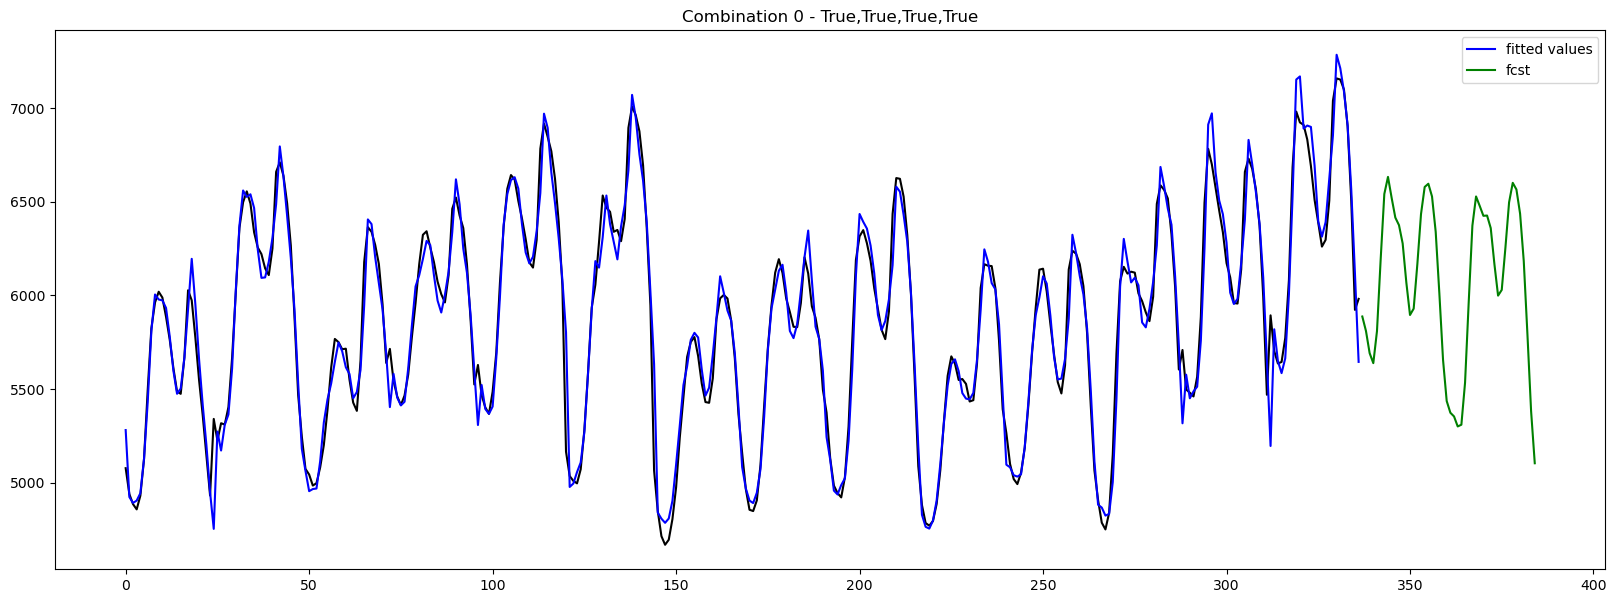

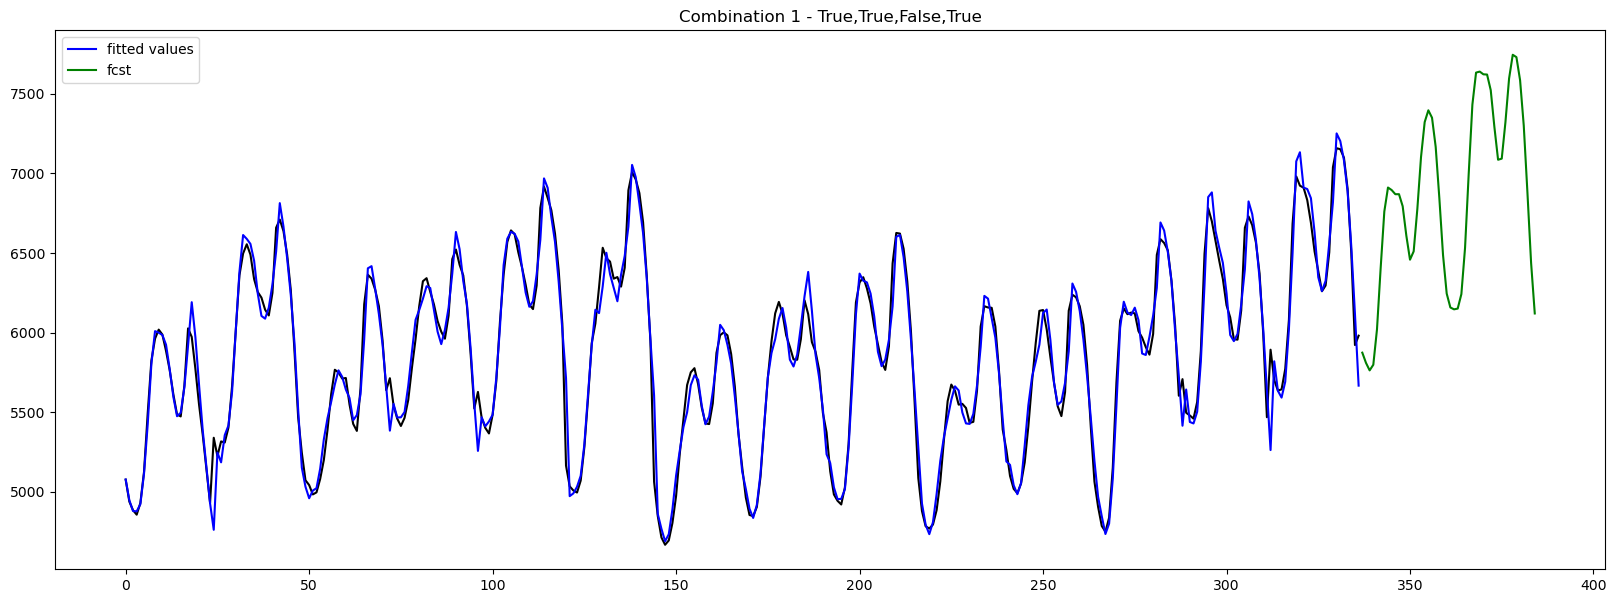

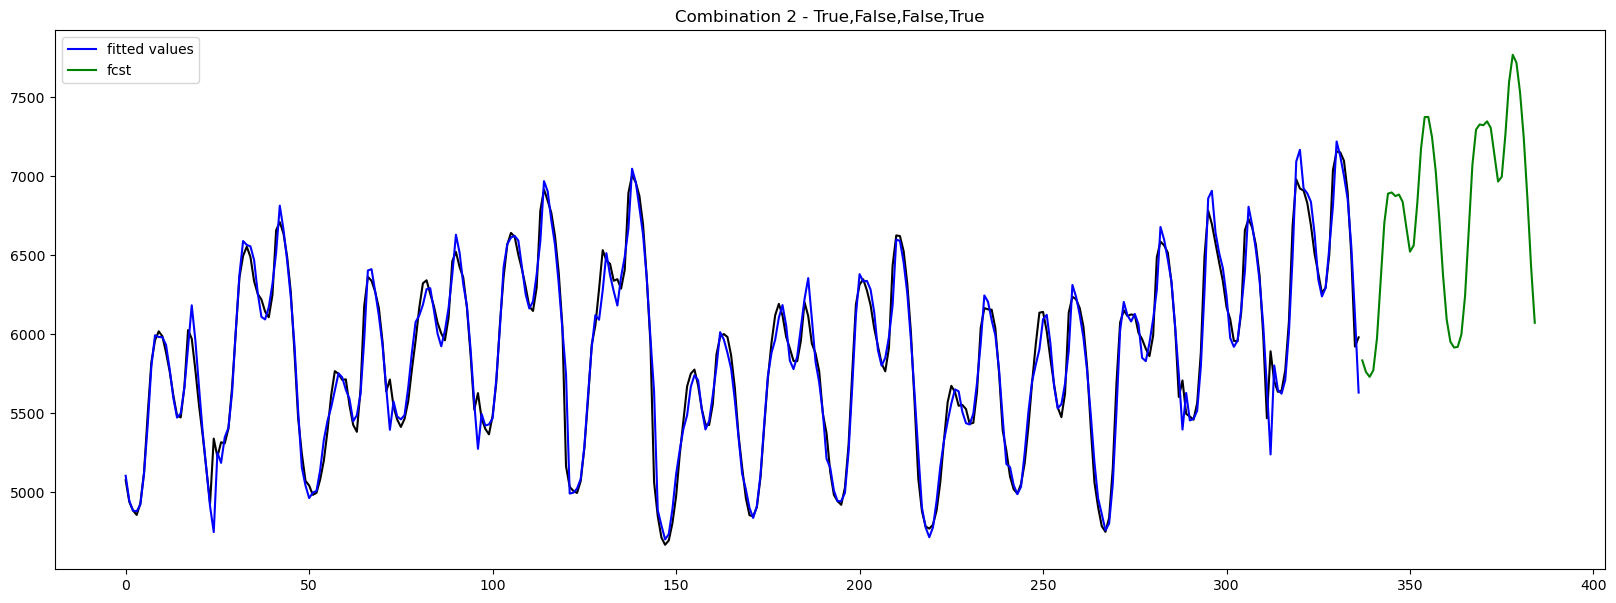

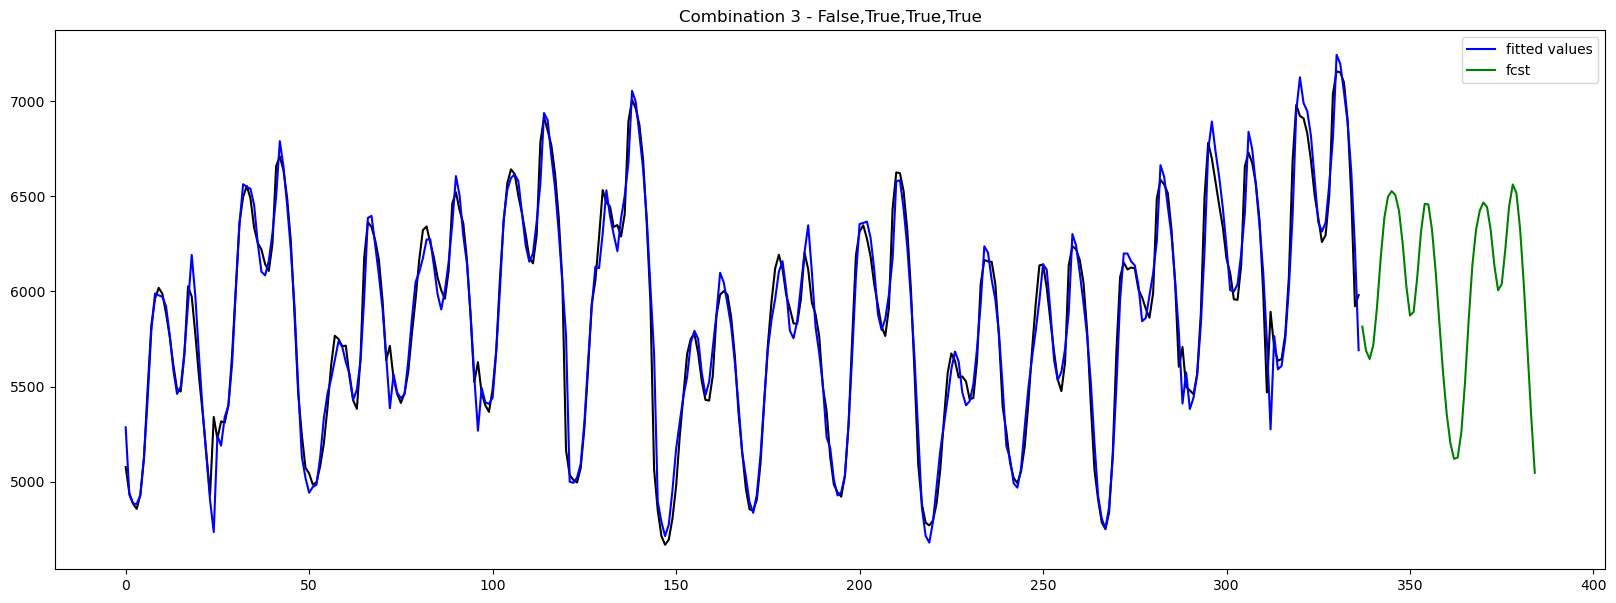

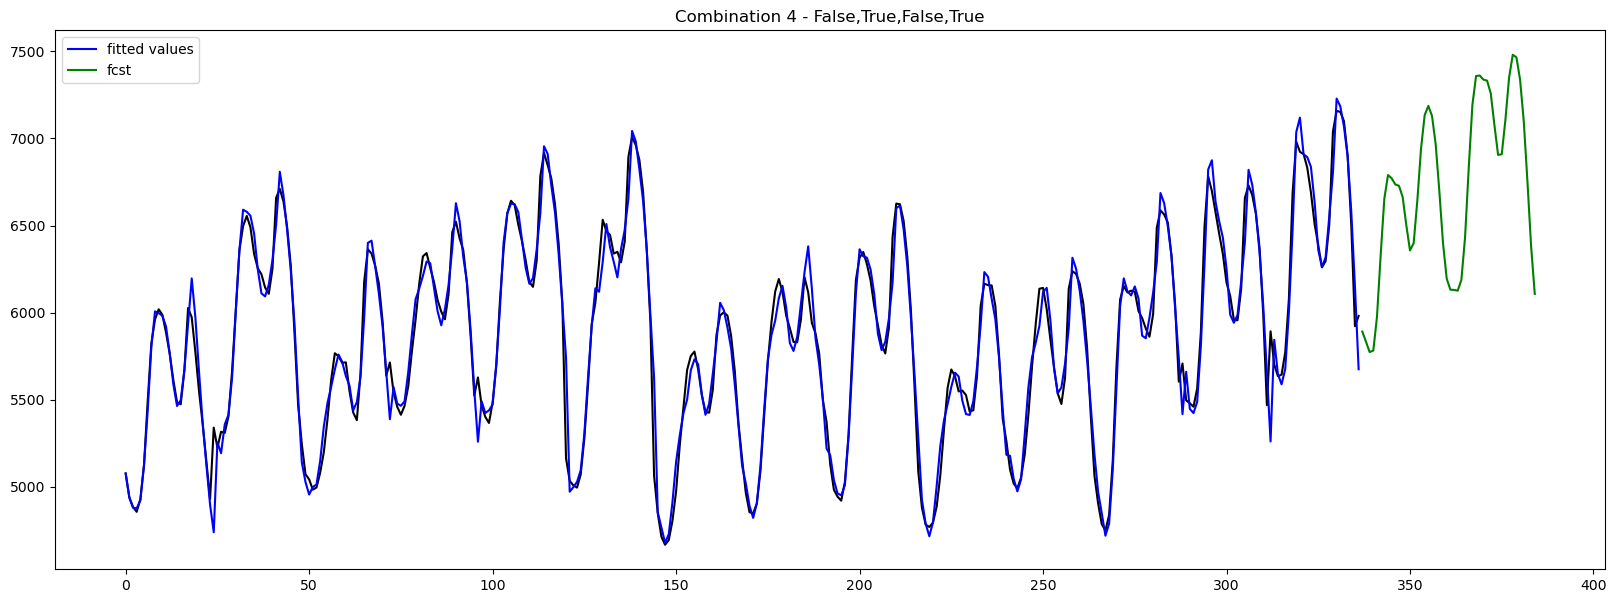

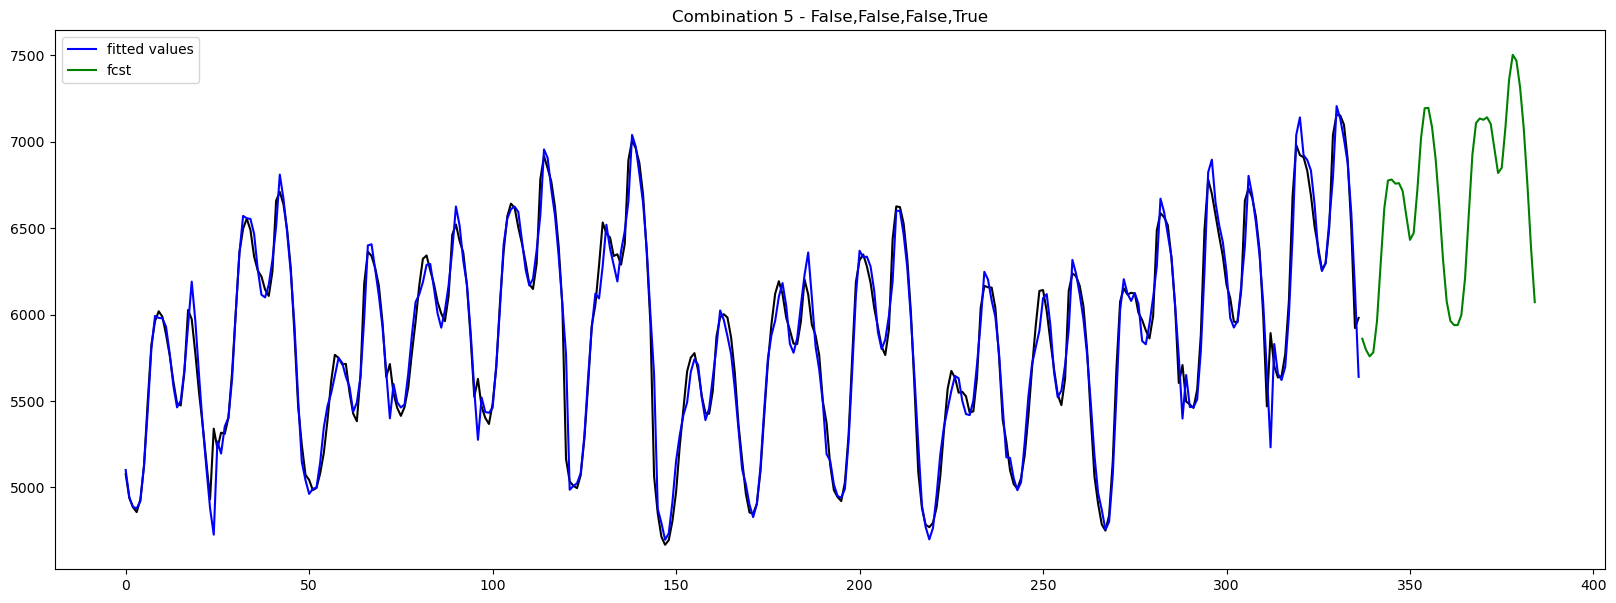

In [30]:
#| hide
# Validation 
combinations = []

for BC in [True, False]: # Possible values for use_boxcox
    for T in [[True, True],[True, False],[False, False]]: # Possible values for use_trend and use_damped_trend  
        for A in [True]: # Possible values for use_arma_errors [True, False]
            combinations.append((BC, T, A))

bc_lower_bound = 0
bc_upper_bound = 1

start = time()

for k in range(len(combinations)): 
    use_boxcox = combinations[k][0]
    use_trend = combinations[k][1][0]
    use_damped_trend = combinations[k][1][1] 
    use_arma_errors = combinations[k][2]

    mod = tbats_model(y, seasonal_periods, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors)

    fcst = tbats_forecast(mod, h=h)

    fitted = mod['fitted']
    forecast = fcst['mean']

    print(mod['aic'])
    print(np.nanmean(abs(mod['errors'])))

    if use_boxcox:
        fitted = InverseBoxCox(fitted, seasonal_periods, mod['BoxCox_lambda'])
        forecast = InverseBoxCox(forecast, seasonal_periods, mod['BoxCox_lambda'])
  
    fitted = fitted.reshape((fitted.shape[1],))
    
    fig, ax = plt.subplots(1, 1, figsize = (20,7))
    plt.plot(np.arange(0, len(y)), y, color='black')
    plt.plot(np.arange(0, len(y)), fitted, color='blue', label = "fitted values")
    plt.plot(np.arange(len(y), len(y)+h), forecast, color = 'green', label = 'fcst')
    plt.legend()
    plt.title('Combination '+str(k)+' - '+str(use_boxcox)+','+str(use_trend)+','+str(use_damped_trend)+','+str(use_arma_errors))

    print('Combination '+str(k)+' validated - '+str(use_boxcox)+','+str(use_trend)+','+str(use_damped_trend)+','+str(use_arma_errors))

end = time()
print('Total execution time: '+str(end-start))